**tmpw0h7p9s5, equation 22**

Ablation study on the DYAMOND data -- setting parameters to 0 and re-tuning

In [35]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
import sys
import os
import gc

sys.path.insert(0, '/home/b/b309170/workspace_icon-ml/symbolic_regression')
from functions import append_dict_to_json
from sklearn import tree

SEED = int(sys.argv[1])
np.random.seed(SEED)

In [36]:
def round_expr(expr):
    d = {}
    for n in expr.atoms(sp.Number):
        d[n] = sp.Number('%.6g'%n)
    return expr.xreplace(d)

In [37]:
no_of_regimes = 2
regime = 1

**Read data**

In [38]:
all_possible_features = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z',\
            'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']

loc_all = {}
for i in range(len(all_possible_features)):
    loc_all[all_possible_features[i]] = i
    
# Features
features = ['rh', 'ta', 'clw', 'cli', 'rh_z']
no_features = len(features)

loc = {}
for i in range(len(features)):
    loc[features[i]] = i

In [39]:
path_data = os.path.join('/home/b/b309170/my_work/icon-ml_data/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND')

# Load the input data and pick the five best features (rh, ta, clw, cli, rh_z)
input_data = np.load(path_data + '/cloud_cover_input_dyamond.npy')
input_data = np.concatenate([np.expand_dims(input_data[:, loc_all[sel_var]], axis=1) for sel_var in features], axis = 1)

output_data = np.load(path_data + '/cloud_area_output_dyamond.npy')

In [40]:
(samples_total, no_of_features) = input_data.shape
(samples_total, no_of_features)

(285179494, 5)

In [41]:
# Construct training and validation data
training_folds = []
validation_folds = []
two_week_incr = samples_total//6

for i in range(3):
    # Note that this is a temporal split since time was the first dimension in the original tensor
    first_incr = np.arange(samples_total//6*i, samples_total//6*(i+1))
    second_incr = np.arange(samples_total//6*(i+3), samples_total//6*(i+4))

    validation_folds.append(np.append(first_incr, second_incr))
    training_folds.append(np.arange(samples_total))
    training_folds[i] = np.delete(training_folds[i], validation_folds[i])

In [42]:
# The second fold yields the best model
flattened_input_train = input_data[training_folds[1]]
flattened_input_valid = input_data[validation_folds[1]]
flattened_output_train = output_data[training_folds[1]]
flattened_output_valid = output_data[validation_folds[1]]
    
# Remove input_data, output_data
del input_data, output_data, training_folds, validation_folds
gc.collect()

14575

In [43]:
if no_of_regimes > 1:
    # Already remove the regime with clw + cli = 0
    reg_not_0_train = np.where(flattened_input_train[:, loc['clw']] + flattened_input_train[:, loc['cli']] > 1e-20)[0]
    flattened_input_train = flattened_input_train[reg_not_0_train]
    flattened_output_train = flattened_output_train[reg_not_0_train]

    reg_not_0_valid = np.where(flattened_input_valid[:, loc['clw']] + flattened_input_valid[:, loc['cli']] > 1e-20)[0]
    flattened_input_valid = flattened_input_valid[reg_not_0_valid]
    flattened_output_valid = flattened_output_valid[reg_not_0_valid]

**Normalize the features**

In [44]:
# Scale the data
mean_all = [4.12205844e-03,2.25493498e-05,3.38180032e-06,2.57065512e+02,6.00030443e+04,5.64080139e+03,2.35046400e-01,1.32776682e+01,6.02512234e-01,9.86270417e+04,-1.27545273e-06,-4.02484958e-10,1.65204582e-08,-4.34660202e-11,4.29441131e-10,-1.82817316e-12,-4.68742483e-03,-7.54899040e-07,-7.51544542e+00,-1.06989723e-04,1.65615172e-03,-9.27604679e-06,-4.76200071e-05,-1.32246548e-07]
std_all = [5.07648249e-03,5.69702638e-05,1.01308124e-05,3.00533874e+01,3.12514292e+04,5.66963918e+03,4.11184302e-01,1.11389888e+01,3.32494615e-01,6.24039256e+03,2.03179260e-06,1.17041141e-08,1.33311867e-07,1.42840744e-09,6.73384546e-09,5.07424672e-11,5.82875686e-03,6.34826092e-05,3.53136052e+00,1.13215264e-02,6.62892130e-03,6.08144307e-05,2.58065098e-04,2.49552692e-06]

mean = np.concatenate([np.expand_dims(mean_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)
std = np.concatenate([np.expand_dims(std_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)

# Work with scaled training folds
train_data_scaled = (flattened_input_train - mean)/std
valid_data_scaled = (flattened_input_valid - mean)/std

Optimize coefficients

In [45]:
# See ~/workspace_icon-ml/symbolic_regression/finding_symmetries/pysr_results_dyamond_on_regimes/no_of_regimes_2/notes.txt
def func(X, a,b,c,d,e,f,g,h,i,j,k):
    x0 = X[:, 0] 
    x1 = X[:, 1] 
    x2 = X[:, 2] 
    x3 = X[:, 3]
    x4 = X[:, 4]
    
    return a*x0 - b*x1 + c*x0*(d*x0 + x1**2) + x4**2*(e*x4 + f) + g - h/(k*x2 + i*x3 + j)

In [46]:
import scipy as sci
from scipy.optimize import minimize

In [47]:
def objective(P, X,Y,force_zero=None):
    '''
        The objective function.
    '''
    a,b,c,d,e,f,g,h,i,j,k = P
    
    # A way to remove terms using a list. Somehow I cannot use locals or exec here...
    if force_zero == 'a': a = 0
    elif force_zero == 'b': b = 0
    elif force_zero == 'c': c = 0
    elif force_zero == 'd': d = 0
    elif force_zero == 'e': e = 0
    elif force_zero == 'f': f = 0
    elif force_zero == 'g': g = 0
    elif force_zero == 'h': h = 0
    elif force_zero == 'i': i = 0
    elif force_zero == 'j': j = 0
    elif force_zero == 'k': k = 0
    
    elif force_zero == 'I1': a = 0; b = 0; c = 0; g = 0
    elif force_zero == 'I2': e = 0; f = 0
            
    train_preds = np.minimum(np.maximum(func(X, a,b,c,d,e,f,g,h,i,j,k), 0), 100) 
    train_mse = np.mean((train_preds - Y)**2, dtype=np.float64)

    return train_mse

T_subset = 10**6
inds = np.random.randint(0, train_data_scaled.shape[0], T_subset)

(a,b,c,d,e,f,g,h,i,j,k) = (38.6562122, 43.53500518, 19.78403208, 1.13637902, 0.35299939, 4.04888686, 44.21730274, 2.03128527, 0.66971589, 0.6409019, 1)

**Evaluate reduced equations**

In [48]:
valid_mses = {}

In [49]:
# First set of parameters
parameters = [None,'a','b','c','d','e','f','g','h','i','j','k','I1','I2']

for par_ind in range(len(parameters)):
    force_zero = parameters[par_ind]

    # Nelder-Mead gives me the same result
    res_bfgs = minimize(objective, (a,b,c,d,e,f,g,h,i,j,k), args=(train_data_scaled[inds], flattened_output_train[inds], force_zero), \
                   method='BFGS', options={'disp': True})

    res_nm = minimize(objective, (a,b,c,d,e,f,g,h,i,j,k), args=(train_data_scaled[inds], flattened_output_train[inds], force_zero), \
                   method='Nelder-Mead', options={'disp': True})

    # Compute objective for both minima
    valid_reg_mse_bfgs = objective(res_bfgs.x, valid_data_scaled, flattened_output_valid, force_zero)
    valid_reg_mse_nm = objective(res_nm.x, valid_data_scaled, flattened_output_valid, force_zero)

    # Compute full valid mse
    mse_reg_0 = 0.0353
    n_0 = 32419018
    n_21 = 62640812
    N = n_0 + n_21

    valid_reg_mse = np.minimum(valid_reg_mse_bfgs, valid_reg_mse_nm)

    print('On the entire dataset')
    print('Valid MSE: %.5f'%((n_0*mse_reg_0 + n_21*valid_reg_mse)/N))

    # Add to dictionary
    if force_zero == None:
        valid_mses['full_eq'] = ((n_0*mse_reg_0 + n_21*valid_reg_mse)/N)
    else:      
        valid_mses[force_zero] = ((n_0*mse_reg_0 + n_21*valid_reg_mse)/N)

         Current function value: 159.724808
         Iterations: 2
         Function evaluations: 429
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 159.724808
         Iterations: 257
         Function evaluations: 420
On the entire dataset
Valid MSE: 103.94659
         Current function value: 225.985551
         Iterations: 47
         Function evaluations: 869
         Gradient evaluations: 79
On the entire dataset
Valid MSE: 146.57637
         Current function value: 274.349883
         Iterations: 62
         Function evaluations: 880
         Gradient evaluations: 80
On the entire dataset
Valid MSE: 178.64328
         Current function value: 547.750377
         Iterations: 5
         Function evaluations: 658
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: 203.445506
         Iterations: 1226
         Function evaluations: 1738
On the entire dataset
Valid MSE: 132.55

In [50]:
with open('/home/b/b309170/workspace_icon-ml/symbolic_regression/finding_symmetries/pysr_results_dyamond_on_regimes/no_of_regimes_2/ablation_study/ablation_study_seed_%d.json'%SEED, 'w') as file:
    json.dump(valid_mses, file)

**Plot results**

In [5]:
with open('/home/b/b309170/workspace_icon-ml/symbolic_regression/finding_symmetries/pysr_results_dyamond_on_regimes/no_of_regimes_2/ablation_study/ablation_study_seed_%d.json'%SEED, 'r') as file:
    valid_mses = json.load(file)

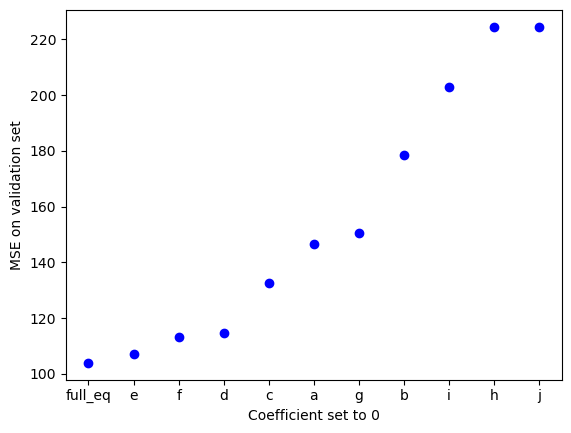

In [31]:
sorted_inds = np.argsort(list(valid_mses.values()))
plt.plot(np.array(list(valid_mses.keys()))[sorted_inds], np.array(list(valid_mses.values()))[sorted_inds], 'bo')
plt.ylabel('MSE on validation set')
plt.xlabel('Coefficient set to 0')
plt.savefig('/home/b/b309170/workspace_icon-ml/symbolic_regression/finding_symmetries/pysr_results_dyamond_on_regimes/no_of_regimes_2/ablation_study/ablation_study_seed_%d.pdf'%SEED)

In [2]:
# Translate coefficients in the normalized form of the equation (a, ..., j) into coefficients (a_1, ..., a_{12}) of the physical form of the equation
translate = {'a': '~$a_5$', 'b': '$a_6$', 'c': '$a_1$, $a_2$, $a_3$, $a_4$', 'd': '$a_1$', 'e': '$a_{10}$', 'f': '$a_{10}$',
            'g': '~$a_7$', 'h': '$I_3 = 0$', 'i': '~$a_{12}$', 'j': '$\epsilon$', 'k': '~$a_{11}$', 'I1': 'I1', 'I2': 'I2', 'full_eq': 'full_eq'}

In [3]:
plt.figure(figsize=(15, 5))
sorted_inds = np.argsort(list(valid_mses.values()))
translated_keys = [translate[key] for key in np.array(list(valid_mses.keys()))[sorted_inds]]

plt.plot(translated_keys, np.array(list(valid_mses.values()))[sorted_inds], 'bo')
plt.ylabel('MSE on validation set')
plt.xlabel('Coefficient set to 0')
plt.savefig('/home/b/b309170/workspace_icon-ml/symbolic_regression/finding_symmetries/pysr_results_dyamond_on_regimes/no_of_regimes_2/ablation_study/ablation_study_seed_%d_translated.pdf'%SEED)

NameError: name 'plt' is not defined